# This is a `basicRaytracing` python-based example of CPU 3D ra-tracing rendering application
## This notebook has been updated by Prof. George Papagiannakis as an introduction to CPU-based computer graphics Elements 
### the code is based on the book "Ray Tracing in One Weekend" by Peter Shirley (https://raytracing.github.io/books/RayTracingInOneWeekend.html)
### *Copyright 2021-2022 Dr. George Papagiannakis,  papagian@csd.uoc.gr*
*All Rights Reserved*
### *University of Crete & Foundation for Research & Technology - Hellas (FORTH)*
---
This notebook is also based on parts of the Python/numpy implementation of Raytracing in One Weekend: https://github.com/RayTracing/raytracing.github.io and the tutorial step-by-step: https://github.com/alfiopuglisi/raytrace_weekend_numpy/blob/master/raytrace_weekend_numpy.ipynb. 


## 1. Overview

The code is based on python libraries and is a basic example of raytracing. 



## 1. Output an image in pure Python and PPM format
The code below outputs a simple background image using the PPM file format based on the original `RayTracingInOneWeekend` book by P. Shirley as found [here](https://github.com/RayTracing/raytracing.github.io/tree/release). 

The PPM file format is a very simple file format that can be used to output an image. The code below outputs a PPM image file that is `image_width` pixels wide and `image_height` pixels high. The image is a gradient that goes from black to *red* on top right, *green* to bottom left and the combination of *red + green = yellow* on bottom right.

In [ ]:
import numpy as np 

# Set image dimensions
image_width = 256
image_height = 256

# Open a file to write the PPM image
with open("output.ppm", "w") as file:
    # Write PPM header
    file.write("P3\n")
    file.write(f"{image_width} {image_height}\n")
    file.write("255\n")

    # Loop over each pixel and calculate color values
    for j in range(image_height):
        # add a progress indicator
        print(f"\rScanlines remaining: {image_height - j}", end=' ', flush=True)
        for i in range(image_width):
            r = i / (image_width - 1)
            g = j / (image_height - 1)
            b = 0.0

            # Convert color values to integers
            ir = int(255.999 * r)
            ig = int(255.999 * g)
            ib = int(255.999 * b)

            # Write the pixel color values to the file
            file.write(f"{ir} {ig} {ib}\n")

This Python script performs the following operations:

- It sets the image `image_width` and `image_height`.
- It opens a new file `output.ppm`` to write the image data.
- It writes the header for the PPM file format.
- It then iterates over each pixel in the image, calculating the *red (r)* and *green (g)* components based on the pixel's position. The *blue* component *(b)* is set to 0.
- It **converts** these *floating-point* color values to **integers** in the **range 0 to 255**.
- Finally, it writes these color values into the file *for each pixel*.
-
When this script is run, it will create a file named `output.ppm`` which will contain the image data in the PPM format, producing a gradient image.

The conversion of the color values to integers between 0 and 255 in the given code is a crucial step for representing colors in digital images, especially in formats like PPM (Portable Pixmap). Here's an explanation of how this conversion works:

1. **Fractional Color Values**: Initially, the color values (`r`, `g`, and `b`) are calculated as fractions. These fractions represent how "intense" or "bright" the color is. A value of 0 means no intensity (black), and a value close to 1 means full intensity. For example, in the code, `r` and `g` values vary from 0 to almost 1 across the width and height of the image.

2. **Scaling to 0-255 Range**: Most digital images use 8 bits per color channel, which allows for 256 different levels of intensity per channel (from 0 to 255). To convert a fractional intensity value to this range, it is multiplied by the maximum intensity level (255). However, to ensure the maximum fractional value (just below 1) maps correctly to 255, the multiplier is slightly less than 256, often chosen as 255.999. This adjustment helps in rounding off the values correctly.

3. **Conversion to Integer**: 
   - After multiplication, the resulting value is in the range from 0 to 255.999.
   - This value is then converted to an integer. In C++, the `static_cast<int>()` is used, and in Python, this is done simply by using `int()`. This step truncates (or effectively rounds down) the decimal part, resulting in an integer value in the desired range of 0 to 255.

4. **Application in the Code**: 
   - In the context of the code, each pixel's color intensity for red (`r`) and green (`g`) is calculated based on its position.
   - `r` varies horizontally, and `g` varies vertically. The blue component (`b`) is set to 0, which means there will be no blue intensity in any pixel.
   - These values are then scaled and converted to integers, giving us the appropriate red and green color values for each pixel to be written in the PPM file.

5. **Print progress indicator**:
   - This Python code uses f-string formatting to embed the expression `image_height - j` within the string. The `end=' '` argument replaces the default newline character that `print` adds to the end of its output with a space. The `flush=True` argument ensures that the output is flushed (i.e., immediately written) to the terminal, which is the equivalent of `std::flush` in C++.

By performing this conversion for each pixel, the code effectively generates the color information for an entire image, where each pixel's color is represented by a set of three integers (representing the red, green, and blue channels) in the range of 0 to 255.

> As described, the image shows a gradient:

- The **red component (R)** increases from *left to right*.
- The **green component (G)** increases from *top to bottom*.
- The **blue component (B)** is consistently zero across the image.

This results in a color transition from black at the top-left corner (where both R and G are zero) to yellow at the bottom-right corner (where both R and G are at their maximum, with no blue component).

In [ ]:
# use the PIL library to display the image we just created
from PIL import Image

# Load the image from a file
image = Image.open("output.ppm")
# Display the image
display(image)

## 2. Output an image using the PIL and numpy libraries 

In this part we are optimizing the above `pure` pythonic translation of the C++ book code to a more efficient implementation using the Python Image Library (PIL) and NumPy libraries, rather than writing PPM files in ASCII . 
PIL can take as an input a [rows,cols,3] a numpy array, which is exactly what we need. To vectorize the color computation, we are going to use one of the numpy "index tricks", *mgrid*. 

Let's start with an **1-D** *mgrid* example:

In [ ]:
import numpy as np

z = np.mgrid[0:5]
print(z)

In the following example, *mgrid* will give us a **2D** `3x2` grid of coordinates. The `x`array *(columns)* represents the **x-coordinates of each point on the grid**, and the `y` array *(rows)* represents the **y-coordinates of each point on the grid**.  The range 0:3 for both x and 0:2 for y specifies that the grid should cover values from 0 to 2 (inclusive), creating a 3x2 grid.

Thus the `x` and `y` arrays are as follows:

```python
x = [[0, 0],
     [1, 1],
     [2, 2]]
y = [[0, 1],
     [0, 1],
     [0, 1]]
```


an example of such a `3x2` grid is shown below:

|          |          |          |
|----------|----------|----------|
| 0,0  | 1,0    | 2,0   |
| 0,1   | 1,1    | 2,1    |
  


![PPM 3x2 example](RayTracing/InOneWeekend/data/PPMexample.png)


In [19]:
import numpy as np

x, y = np.mgrid[0:3,0:2]
print('x coordinates:\n', x)
print('y coordinates:\n',y)

print('\n(x,y) first row pair:')
for pair in zip(x[0,:], y[0,:]):
    print(pair)

print('\n(x,y) all pairs:')
x_flat = x.flatten()
y_flat = y.flatten()

for pair in zip(x_flat, y_flat):
    print(pair)

x coordinates:
 [[0 0]
 [1 1]
 [2 2]]
y coordinates:
 [[0 1]
 [0 1]
 [0 1]]

(x,y) first row pair:
(0, 0)
(0, 1)

(x,y) all pairs:
(0, 0)
(0, 1)
(1, 0)
(1, 1)
(2, 0)
(2, 1)


[0 0 1 1 2 2]
[0 1 0 1 0 1]


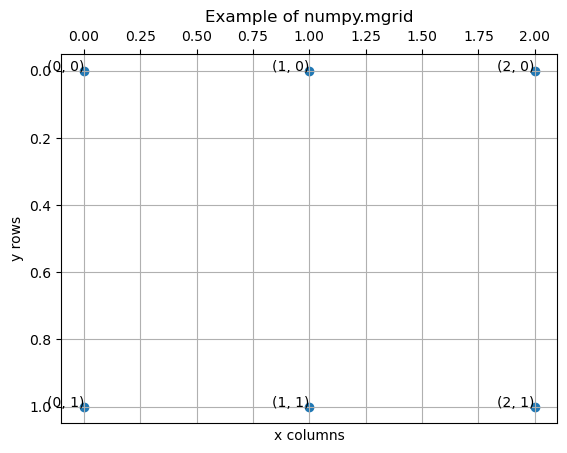

In [16]:
#draw the above numpy mgrid example
import matplotlib.pyplot as plt

# Plot the meshgrid
#plt.scatter(x, y)
x_flat = x.flatten()
print(x_flat)
y_flat = y.flatten()
print(y_flat)

plt.scatter(x_flat, y_flat)
for i in range(len(x_flat)):
    plt.text(x_flat[i], y_flat[i], f'({x_flat[i]}, {y_flat[i]})', ha='right')


plt.xlabel('x columns')
plt.ylabel('y rows')
plt.title('Example of numpy.mgrid')
plt.grid(True)
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top() 
plt.show()


We will also convert the indexes to floating point. The image is pre-allocated in order to allow numpy to work on big arrays, and instead of looping over each element, we use numpy to calculate all pixel values in one go.

Notice how the grid and the image are height,width instead of the opposite. This is because numpy works in rows,columns order, and the number of rows corresponds to the image height.

In [ ]:
from PIL import Image

# Image
width = 256
height = 256

# Create numpy array representing the image
# The shape of the array will be (height, width, 3)
# The '3' represents the RGB values
# The dtype='uint8' means values will be unsigned integers (0 to 255)
# The initial values are all 0, which represents black
# The array is stored in a variable named 'img'
ii, jj = np.mgrid[:float(height), :float(width)]
print('ii is:\n', ii)
print('jj is:\n',jj)
# Create a numpy array of zeros that is the same size as the image
img = np.zeros((height, width, 3), dtype='uint8')

# Set the RGB values in the numpy array
# The first line, r = jj/(width-1), is calculating the red component (r) of the color for each pixel. 
# The red component is determined by the x position of the pixel: pixels on the left (where jj is small) 
# will have a low red component, and pixels on the right (where jj is large) will have a high red component.
# division with `width-1` is to normalize the value to be between 0 and 1
r = jj/(width-1)
# similar calculation for green component
g = ii/(height-1)
b = 0.25

# Set the RGB values in the numpy array
# The first index is the row number (i.e. y coordinate)
# The second index is the column number (i.e. x coordinate)
# The third index is the color channel (0=red, 1=green, 2=blue)
# The values are multiplied by 255 to convert from floating point
#   values in the range 0.0 to 1.0 to integer values in the range 0 to 255
img[:,:,0] = 255.299*r
img[:,:,1] = 255.299*g
img[:,:,2] = 255.299*b

# Create an image from the numpy array
image = Image.fromarray(img)
# Save the image to a file
image.save('img.ppm')
# Display the image using PIL
display(image)

## 3. The vec3 class

We need a basic vec3 type like the one in the C++ book. Following Python traditions, class members are not encaspsulated with getters/setters (if needed, you can always turn them into properties later, without breaking backward compatibility). We also add a few useful methods, that will allow us to use the Vec3 almost as if it was a regular numpy array.

Almost all graphics programs have some class(es) for storing geometric vectors and colors. In many systems thesevectors are 4D (3D position plus a homogeneous coordinate for geometry, or RGB plus an alpha transparencycomponent for colors). For our purposes, three coordinates suffice. We’ll use the same class vec3 for colors,locations, directions, offsets, whatever. Some people don’t like this because it doesn’t prevent you from doingsomething silly, like subtracting a position from a color. They have a good point, but we’re going to always take the“less code” route when not obviously wrong. In spite of this, we do declare two aliases for vec3: point3 and color.Since these two types are just aliases for vec3, you won't get warnings if you pass a color to a function expecting apoint3, and nothing is stopping you from adding a point3 to a color, but it makes the code a little bit easier to readand to understand.

In [ ]:
import numpy as np

class Vec3:
    def __init__(self, e0=0, e1=0, e2=0):
        self.e = np.array([e0, e1, e2])

    def x(self):
        return self.e[0]

    def y(self):
        return self.e[1]

    def z(self):
        return self.e[2]

    def __neg__(self):
        return Vec3(-self.e[0], -self.e[1], -self.e[2])

    def __getitem__(self, i):
        return self.e[i]

    def __setitem__(self, i, value):
        self.e[i] = value

    def __iadd__(self, other):
        self.e += other.e
        return self

    def __imul__(self, t):
        self.e *= t
        return self

    def __itruediv__(self, t):
        self.e /= t
        return self
    
    def __mul__(self, scalar):
        return Vec3(self.x*scalar, self.y*scalar, self.z*scalar)

    def length(self):
        return np.linalg.norm(self.e)

    def length_squared(self):
        return np.dot(self.e, self.e)

    def near_zero(self):
        s = 1e-8
        return (np.abs(self.e[0]) < s) and (np.abs(self.e[1]) < s) and (np.abs(self.e[2]) < s)

    @staticmethod
    def random():
        return Vec3(np.random.random(), np.random.random(), np.random.random())

    @staticmethod
    def random_range(min, max):
        return Vec3(np.random.uniform(min, max), np.random.uniform(min, max), np.random.uniform(min, max))

# Utility Functions
def random_in_unit_disk():
    while True:
        p = Vec3(np.random.uniform(-1,1), np.random.uniform(-1,1), 0)
        if p.length_squared() < 1:
            return p

def random_in_unit_sphere():
    while True:
        p = Vec3.random_range(-1, 1)
        if p.length_squared() < 1:
            return p

def random_unit_vector():
    return unit_vector(random_in_unit_sphere())

def random_on_hemisphere(normal):
    on_unit_sphere = random_unit_vector()
    if dot(on_unit_sphere, normal) > 0.0:
        return on_unit_sphere
    else:
        return -on_unit_sphere

def reflect(v, n):
    return v - 2 * dot(v, n) * n

def refract(uv, n, etai_over_etat):
    cos_theta = min(dot(-uv, n), 1.0)
    r_out_perp = etai_over_etat * (uv + cos_theta * n)
    r_out_parallel = -np.sqrt(np.abs(1.0 - r_out_perp.length_squared())) * n
    return r_out_perp + r_out_parallel

def dot(u, v):
    return np.dot(u.e, v.e)

def cross(u, v):
    return Vec3(*np.cross(u.e, v.e))

def unit_vector(v):
    return v / v.length()

# point3 is an alias for vec3
Point3 = Vec3

# Overloaded Operators
def add(u, v):
    return Vec3(u.e[0] + v.e[0], u.e[1] + v.e[1], u.e[2] + v.e[2])

def sub(u, v):
    return Vec3(u.e[0] - v.e[0], u.e[1] - v.e[1], u.e[2] - v.e[2])

def mul(u, v):
    if isinstance(v, Vec3):
        return Vec3(u.e[0] * v.e[0], u.e[1] * v.e[1], u.e[2] * v.e[2])
    elif isinstance(v, (int, float)):
        return Vec3(u.e[0] * v, u.e[1] * v, u.e[2] * v)

def truediv(v, t):
    return Vec3(v.e[0] / t, v.e[1] / t, v.e[2] / t)


## 4. Rays, a simple camera, and background

### 4.1 The ray class

A direct translation of the C++ one. We add some useful methods to get/set a ray subset and get the number of rays.

In [ ]:
"""
class Ray:
    def __init__(self, origin, direction):
        self.origin = origin
        self.direction = direction

    def at(self, t):
        return self.origin + self.direction*t
    
    def __getitem__(self, idx):
        return Ray(self.origin[idx], self.direction[idx])

    def __setitem__(self, idx, other):
        self.origin[idx] = other.origin
        self.direction[idx] = other.direction
    
    def __len__(self):
        return self.origin.x.size
"""
class Ray:
    def __init__(self, origin, direction):
        self.orig = origin
        self.dir = direction

    def origin(self):
        return self.orig

    def direction(self):
        return self.dir

    def at(self, t):
        return self.orig + t * self.dir